In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from moviepy.editor import VideoFileClip

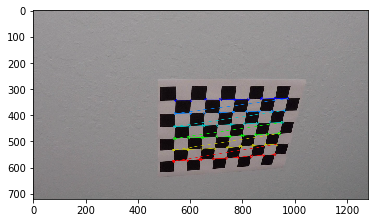

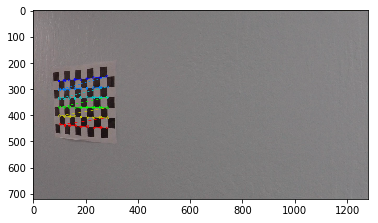

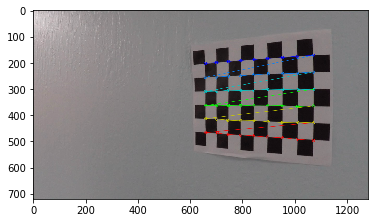

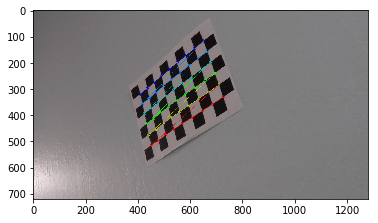

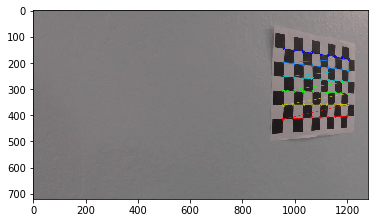

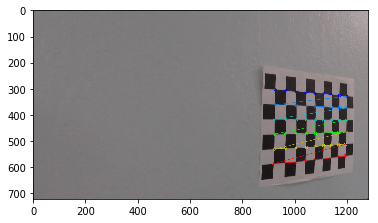

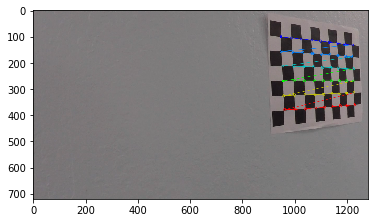

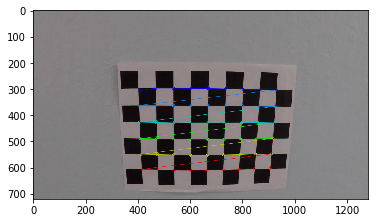

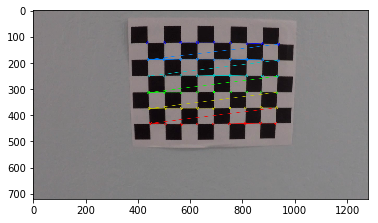

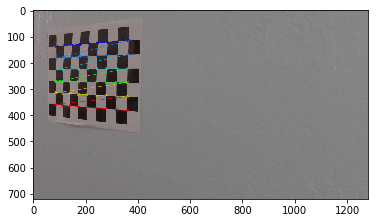

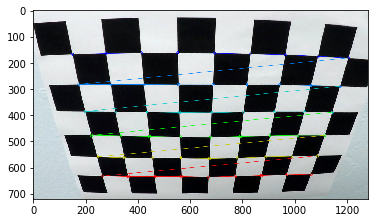

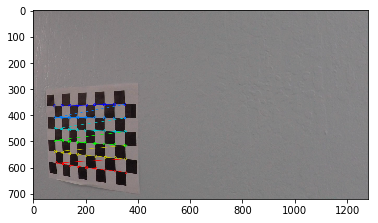

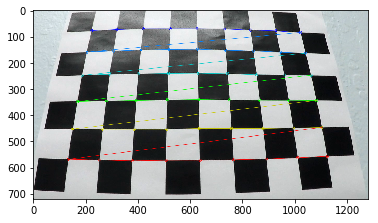

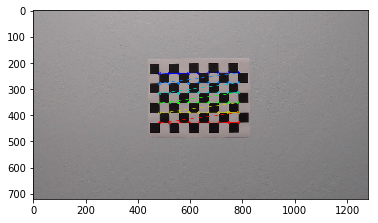

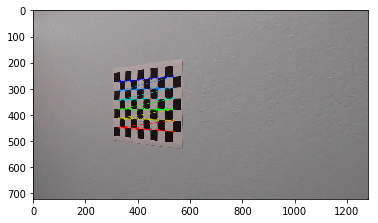

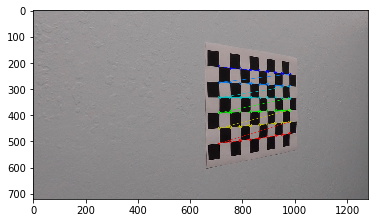

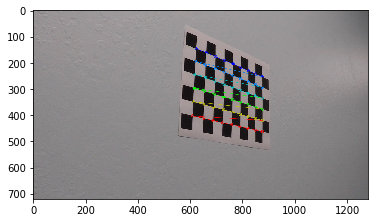

In [54]:
path='camera_cal'
cal_imgs=os.listdir(path)

(nx, ny)=(9, 6)
img_points=[]
obj_points=[]
objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2]=np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for name in cal_imgs:
    img=cv2.imread(path+'/'+name)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners=cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret==True:
        img_points.append(corners)
        obj_points.append(objp)
        cv2.drawChessboardCorners(img, (nx,ny),corners, ret)
        plt.imshow(img)
        plt.show()
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape, None, None)

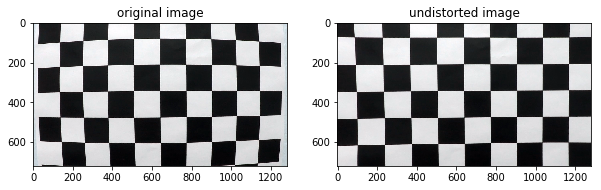

In [174]:
img=cv2.imread('camera_cal/calibration1.jpg')
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('undistorted image')
undistort=undistorted(img, mtx, dist)
plt.imshow(undistort)
plt.show()

In [59]:
def undistorted(img, mxt, dist):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst=cv2.undistort(img, mtx, dist, None, mtx)
    return dst

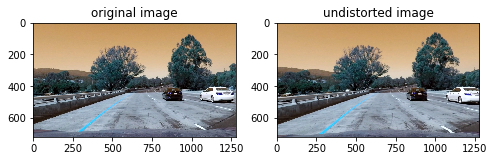

In [63]:
path='test_images/test1.jpg'
img=cv2.imread(path)
undistort=undistorted(img, mtx, dist)
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undistort)
plt.show()

In [70]:

def abs_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scale_sobelx=np.uint8(255*sobelx/np.max(sobelx))
    sx_binary=np.zeros_like(scale_sobelx)
    sx_binary[(scale_sobelx>=thresh[0])&(scale_sobelx<=thresh[1])]=1
    return sx_binary

def hls_thresh(img, thresh_s=(0,255)):
    hls=cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel=hls[:,:,2]
    l_channel=hls[:,:,1]
    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel>=thresh_s[0])&(s_channel<=thresh_s[1])]=1
    return s_binary

def rgb_thresh(img,  thresh=(0,255)):
    r_channel=img[:,:,2]
    r_binary=np.zeros_like(r_channel)
    r_binary[(r_channel>=thresh[0])&(r_channel<=thresh[1])]=1
    return r_binary

def hsv_thresh(img, thresh=(0,255)):
    hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_channel=hsv[:,:,0]
    h_binary=np.zeros_like(h_channel)
    h_binary[(h_channel>=thresh[0])&(h_channel<=thresh[1])]=1
    return h_binary

def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray, cv2.CV_64F ,0, 1)
    abs_sobel=np.sqrt(sobelx**2+sobely**2)
    scale_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary=np.zeros_like(scale_sobel)
    mag_binary[(scale_sobel<=thresh[1]) & (scale_sobel>=thresh[0])]=1
    return mag_binary

def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    sobely=np.absolute(cv2.Sobel(gray, cv2.CV_64F ,0, 1,ksize=sobel_kernel))
    dir_sobel=np.arctan2(sobely, sobelx)
    binary_output=np.zeros_like(dir_sobel)
    binary_output[(dir_sobel<=thresh[1]) & (dir_sobel>=thresh[0])]=1
    return binary_output

def combine_thresh(img, thresh_x=(20,75), thresh_s=(180,230)):
    dst=undistorted(img, mtx, dist)
    img=cv2.GaussianBlur(dst, (5,5),0)
    sx_binary=abs_sobel_thresh(img, 3, thresh_x)
    s_binary=hls_thresh(img,thresh_s)
    color_binary=np.zeros_like(sx_binary)
    color_binary[((sx_binary==1)|(s_binary==1))]=1
    return color_binary

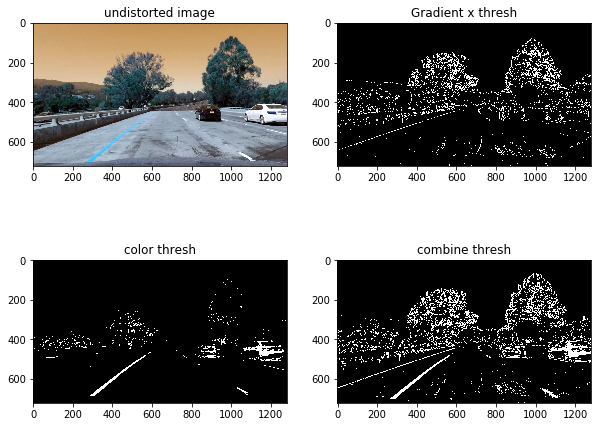

In [166]:
sobel_x_thresh=abs_sobel_thresh(img, 3, (20,100))
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.title('undistorted image')
plt.imshow(undistort,cmap = 'Greys_r')


plt.subplot(2,2,2)
plt.title('Gradient x thresh')
sobel_x_thresh*=255
plt.imshow(sobel_x_thresh,cmap = 'Greys_r')


plt.subplot(2,2,3)
plt.title('color thresh')
color_thresh=hls_thresh(img, (150,255))
color_thresh*=255
plt.imshow(color_thresh,cmap = 'Greys_r')


plt.subplot(2,2,4)
plt.title('combine thresh')
combine=combine_thresh(img, thresh_x=(20,75), thresh_s=(150,255))
combine*=255
plt.imshow(combine,cmap = 'Greys_r')
plt.show()

In [158]:
src = np.float32([[293, 668], [587, 458], [703, 458], [1028, 668]])
dst = np.float32([[310, 720], [310, 0],[950, 0], [950, 720]])

M=cv2.getPerspectiveTransform(src, dst)
Minv=cv2.getPerspectiveTransform(dst, src)


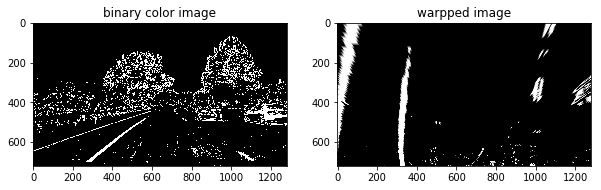

In [167]:
warp=cv2.warpPerspective(combine, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title('binary color image')
plt.imshow(combine,cmap='Greys_r')

plt.subplot(1,2,2)
plt.title('warpped image')
plt.imshow(warp,cmap='Greys_r')
plt.show()

In [168]:
def fit_lines(binary_img,plot=True):
    histogram=np.sum(binary_img[binary_img.shape[0]//2:,:],axis=0)
    out_img = np.dstack((binary_img, binary_img, binary_img))
    out_img=np.uint8(out_img*255)
    out_img=255 * out_img
    midpoint=histogram.shape[0]//2
    left_base=np.argmax(histogram[:midpoint])
    right_base=np.argmax(histogram[midpoint:])+midpoint
    nwindows=9
    window_height = np.int(binary_img.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_current=left_base
    right_current=right_base
    margin=80
    minpix=60
    left_lane_inds=[]
    right_lane_inds=[]
    
    for window in range(nwindows):
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = left_current - margin
        win_xleft_high = left_current + margin
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                           (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)


    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if plot==True:
        fig = plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit, out_img

def fit_lines_continous(binary_warped, left_fit, right_fit, nwindows=9,plot=True):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
# Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    if plot==True:
# Draw the lane onto the warped blank image
        cv2.fillPoly(out_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(out_img, np.int_([right_line_pts]), (0,255, 0))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit, out_img

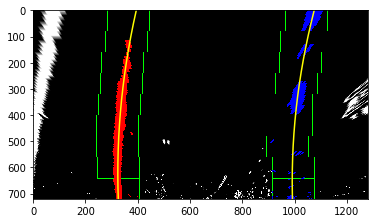

In [171]:
left_fit,right_fit,out_img=fit_lines(warp, True)
plt.show()

In [149]:
def cal_curverature(img_shape, left_fit, right_fit):
    ploty=np.linspace(0, img_shape[0]-1, num=img_shape[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
# Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    leftx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    rightx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    xoffset=(left_fit_cr[2]+right_fit_cr[2])/2-img.shape[1]*xm_per_pix/2
    return left_curverad, right_curverad, xoffset

In [150]:

def warp_perspective_back(img, warped, left_fit, right_fit,Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty=np.linspace(0, img.shape[0]-1, num=img.shape[0])
    leftx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    rightx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

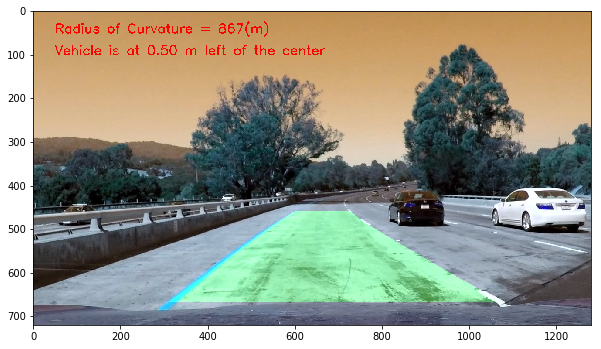

In [172]:
left_curverad, right_curverad, xoffset=cal_curverature(img.shape, left_fit, right_fit)
cur=(left_curverad+right_curverad)/2
result=warp_perspective_back(img, warp, left_fit, right_fit,Minv)
font= cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(result, 'Radius of Curvature = %d(m)' % (cur), (50, 50), font, 1, (255, 0, 0), 2)
direction='left' if xoffset>0 else 'right'
cv2.putText(result, ('Vehicle is at %.2f m %s of the center' % (np.abs(xoffset),direction)), (50, 100), font, 1, (255, 0, 0), 2)
plt.figure(figsize=(10,8))
plt.imshow(result)
plt.show()

In [164]:
def sanity_check(left_fit, right_fit):
    if len(left_fit)<3 or len(right_fit)<3:
        return False
   
    ploty=np.linspace(0, 720, 30)
    leftx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    rightx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    mean_dist=np.mean(rightx-leftx)
    dmin=np.min(rightx-leftx)
    dmax=np.max(rightx-leftx)
    if mean_dist>=550 and mean_dist<=750:
        status=True
    else:
        return False
    if  dmax-dmin<=80:
        status=True
    else:
        return False
    return status
    


def preprocess(img):
    global left_fit_global
    global right_fit_global
    global counter
    color_binary=combine_thresh(img,(20,75),(150,255))
    warp=cv2.warpPerspective(color_binary, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    if counter==0:
        left_fit_global, right_fit_global, _=fit_lines(warp,False)
        counter+=1
    else:
        left_fit, right_fit,_=fit_lines_continous(warp,left_fit_global, right_fit_global,plot=False)
        if sanity_check(left_fit, right_fit)==True:
            counter+=1
            left_fit_global,right_fit_global=left_fit,right_fit
        else:
            left_fit_gloabl,right_fit_global,_=fit_lines(warp,False)
            counter+=1
    result=warp_perspective_back(img, warp, left_fit_global, right_fit_global,Minv)
    return result

In [173]:
counter=0
left_fit_global,right_fit_global=None, None
output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(preprocess) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:21<00:00,  8.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

Wall time: 2min 22s
1261


In [27]:
counter=0
left_fit_global,right_fit_global=None, None
output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(preprocess) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:02<00:00,  7.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

Wall time: 1min 3s
486
